# Programming Assingment 5 (PA5)
**Strong Recommendation**: Please use google COLAB for running your code or use a device with available GPU. 

**Google COLAB**: Simply upload the assignment notebook to your google drive and open it with google COLAB. 

**Make sure to select GPU in the setting for COLAB**. That can be done by going to 

`runtime->change runtime type->Hardware Accelerator->GPU`



## Part 1 - Multliclass Classification over images using CNN's over MNIST
Setting some hyperparameters and making sure we have a GPU

In [11]:
%matplotlib inline
import numpy as np 
import torch
import torchvision
import torchvision.transforms as transforms
import random


# Set the device to use
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Hyperparameters
num_epochs = 10
num_classes = 10
batch_size = 256

# Fixing Random Seed for Reproducibility
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)


# Tests
print(str(device))
assert("cuda" in str(device))

cuda:0


### Loading MNIST
Here we are loading the MNIST dataset. This dataset consists of 60,000 train data and 10,000 test data. 

Each data is 28-by-28 image which and labels are 0 to 9 (representing digits 0-9)


In [0]:
from torch.utils.data import DataLoader

# transforms to apply to the data
# mean 0.1307, std 0.3081
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

# MNIST datasets
train_dataset = torchvision.datasets.MNIST(root="./data", train=True, transform=trans, download=True)
test_dataset = torchvision.datasets.MNIST(root="./data", train=False, transform=trans)

# MNIST loaders
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)


# Tests
assert(len(train_loader)*batch_size >= 60000)
assert(len(test_loader)*batch_size >=10000)

### Building the network
We want to have the following architecture

 

1.   2D Convolutional Layer with 32 output channels, 5-by-5 kernel, and padding of size 2, activation function RELU
2.   Maxpooling with 2-by-2 kernel and stride of size 2
3.   2D Convolutional Layer with 64 output channels, 5-by-5 kernel, and padding of size 2, activation function RELU
4.   Maxpooling with 2-by-2 kernel and stride of size 2
5.   Fully connected Layer with output size 512 with RELU activation
6.   Fully connected Layer with output of size 10 (**no activation function**)

Input:
0. Input is 28-by-28 image with only 1 channel


In [0]:
import torch.nn as nn
import torch.nn.functional as F


# ACT1-ACT9:
# Complete the code below based on the architecture described above
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, padding=2)  # ACT1 
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # ACT2
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2)  # ACT3
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # ACT4

        # ACT5 compute the size of the the input for the first fully connected layer
        # You can track what happens to a 28-by-28 images when passes through the previous layers
        # you will endup with 64 channels each of size x-by-x therefore 
        # the size of input is (64*x*x) - you need to compute x and fill the code below
        self.size_linear =  64 * 7 * 7
        self.fc1 = nn.Linear(self.size_linear, 512)
        self.fc2 = nn.Linear(512, 10)
    
    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x))) 
        x = self.pool1(F.relu(self.conv2(x))) #ACT7
        x = x.view(-1, self.size_linear)  # flatten data to connect to fc layers
        x = F.relu(self.fc1(x)) #ACT8
        x = self.fc2(x) #ACT9
        return x

# Tests
with torch.no_grad():
    # making 100 random images 1 channel 28-by-28
    a = torch.rand(100, 1, 28, 28)
    test_net = Net()
    #passing through network
    b = test_net.forward(a)
    # the output should have size (100,10)
    assert(b.size() == (100, 10))

### Building the trainer
When we call 

```
trainer.train(epochs)
```
trainer for *epcohs* times goes over all the data. It iterates over batches of data, passes it through network, computes the loss and the gradients and lets the optimizer (SGD in our) update the parameteres. Look at the next cell after this one to see how we instantiate a trainer.





In [0]:
# ACT10-ACT14 Please fill the code below (hint: all of them are one line)
class Trainer():
    def __init__(self, net=None, optim=None, loss_function=None):
        self.net = net
        self.optim = optim
        self.loss_function = loss_function

    def train(self,epochs):
        losses = []
        for epoch in range(epochs):
            epoch_loss = 0.0
            epoch_steps = 0

            for data in train_loader:                
                # Moving this batch to GPU
                # Note that X has shape (batch_size, number of channels, height, width)
                # which is equal to (256, 1, 28, 28) since our default batch_size = 256 and 
                # the image has only 1 channel
                X = data[0].to(device)
                y = data[1].to(device)
                
                # ACT10: Zero the gradient in the optimizer i.e. self.optim
                self.optim.zero_grad()

                # ACT11: Getting the output of the Network
                output = self.net(X)

                # ACT12: Computing loss using loss function i.e. self.loss_function
                loss = self.loss_function(output, y)

                # ACT13: compute gradients of parameteres (backpropagation)
                loss.backward()

                # ACT14: Call the optimizer i.e. self.optim
                self.optim.step() 

                # Increase epoch's loss and steps
                epoch_loss += loss.item()
                epoch_steps += 1
        
            # calculate the average loss per epoch
            losses.append(epoch_loss / epoch_steps)
            print("epoch [%d]: loss %.3f"%(epoch+1,losses[-1]))
        return losses


### Training the network 
Let's find the right learning rate. 

In [15]:
import torch.optim as optim

# ACT15 try different learning rates for SGD to see which one works
# do not try learning rates greater than 1!
# number of epochs is fixed do not change it
# we want the last epoch's loss to be less thant 0.03


learning_rate = 0.05  # ACT15

net = Net()
a = net.to(device)
opt = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
loss_function = nn.CrossEntropyLoss()

trainer  = Trainer(net=net, optim=opt, loss_function=loss_function)

losses = trainer.train(num_epochs)

# Tests
assert(losses[-1] <= 0.03)
assert(len(losses) == num_epochs)

epoch [1]: loss 0.300
epoch [2]: loss 0.045
epoch [3]: loss 0.030
epoch [4]: loss 0.021
epoch [5]: loss 0.015
epoch [6]: loss 0.012
epoch [7]: loss 0.009
epoch [8]: loss 0.008
epoch [9]: loss 0.006
epoch [10]: loss 0.005


Text(0, 0.5, 'Losses')

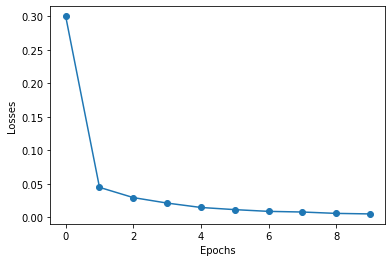

In [16]:
import matplotlib.pyplot as plt
# ACT16 plot the training loss (y-axis) vs epoch number (x-axis)
# using the losses you computed in previous step

plt.plot(losses, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Losses')

### Accuracy of our network on test data
As you will see we will get accuracy of >98% on the test data.

In [17]:
err = 0
tot = 0
with torch.no_grad():
    for data in test_loader:
        # ACT17 retrieve X and y for this batch from data and 
        # move it to GPU (hint: look at what we did in the trainer)
        X = data[0].to(device)
        y = data[1].to(device)

        # raw output of network for X
        output = net(X)
        
        # let the maximum index be our predicted class
        _, yh = torch.max(output, 1) 

        # tot will be 10,000 at the end, total number of test data
        tot += y.size(0)

        # ACT18 add to err the number of missclassification, i.e. number of indices 
        # where yh and y are not equal
        # note that y and yh are vectors of size = batch_size = (256 in our case)
        err += (yh != y).sum().item()

print('Accuracy of prediction on test digits: %5.2f%%' % (100 - 100 * err / tot))

# Tests
assert((100 - 100 * err / tot) >= 98)
assert(tot == 10 * 1000)

Accuracy of prediction on test digits: 99.26%


### Visualizing CNN layers

In [0]:
import numpy as np
import matplotlib.pyplot as plt

# function to normalize a 2d image (input type = numpy 2d array)
def normalize_image(npimg):
    npimg = (npimg - np.mean(npimg)) / np.std(npimg)
    npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
    return npimg

#### Visualizing each filter separately in the first layer

* Our first layer was a 2d convolutional layer with 32 output channels and 5-by-5 kernel
* Therefore we have 32 different learnt filters each has size (1,5,5) or equivalently each filter is a 5-by-5 array of weights 
* Let's look at this filter as a 5-by-5 grayscale image and plot it


After running this cell, answer the following question:


**ACT19**
**briefly explain what these filters are detecting**


#### ACT 19:

As mentioned above, the filters are an array of weights. Based on the plot, lighter pixels correspond to weights with higer values (e.g. more activated) and darker ones the opposite (e.g. less important). In a general sense, these filters are supposed to detect features of the image they are applied to, such as low-level ones (background info, "is this a 0 or a 1") in the case of the first convolution layer we are looking at. As we progress forward in the convolution architecture, lower-level features are detected instead (like curves, edges, circles).

torch.Size([32, 1, 5, 5])


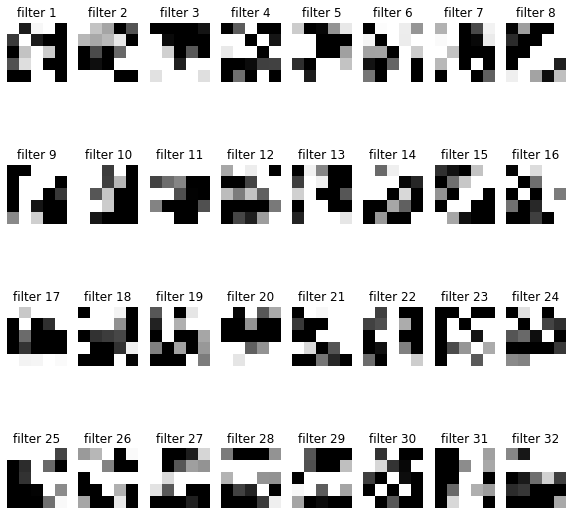

In [19]:
# ACT20
# fill the code below
# hint: start by looking at size of net.conv1.weight 
print(net.conv1.weight.size())

with torch.no_grad():
    plt.figure(figsize=(10,10))
    for i in range(32):
        plt.subplot(4, 8, i + 1)
        
        # 5-by-5 numpy array corresponding to i-th filter 
        npimg = net.conv1.weight[i, :, :, :].cpu().numpy()
        npimg = npimg.reshape(5, 5)
        npimg = normalize_image(npimg)

        plt.imshow(npimg, cmap="gray", vmin=0, vmax=1)
        plt.title("filter " + str(i+1))
        plt.axis("off")
    plt.show()

### Visualizing input after applying first layer


*   First layer has 32 filters
*   since padding is 2 and kernel is 5-by-5 each output channel will be agian 28-by-28
* Let's visualize each of these 32 pictures for each of sample digits

After running this cell, answer the following question:

**ACT21**
**briefly explain what these images represent**



### ACT 21
These images are called feature maps, and depict distilled versions of the original input images with different attributes or characteristics underscored. For example, some of the feature maps emphazise the contrast between the digit and the background, while others highlight portions of the "boundary" of the digit or stroke intensity. In other words, the convolution filters distributedly create multiple "perspectives" of a same image, thus increasing the robustness of our CNN predictor.

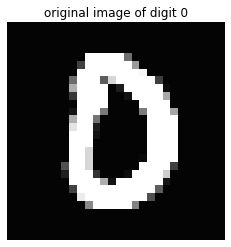

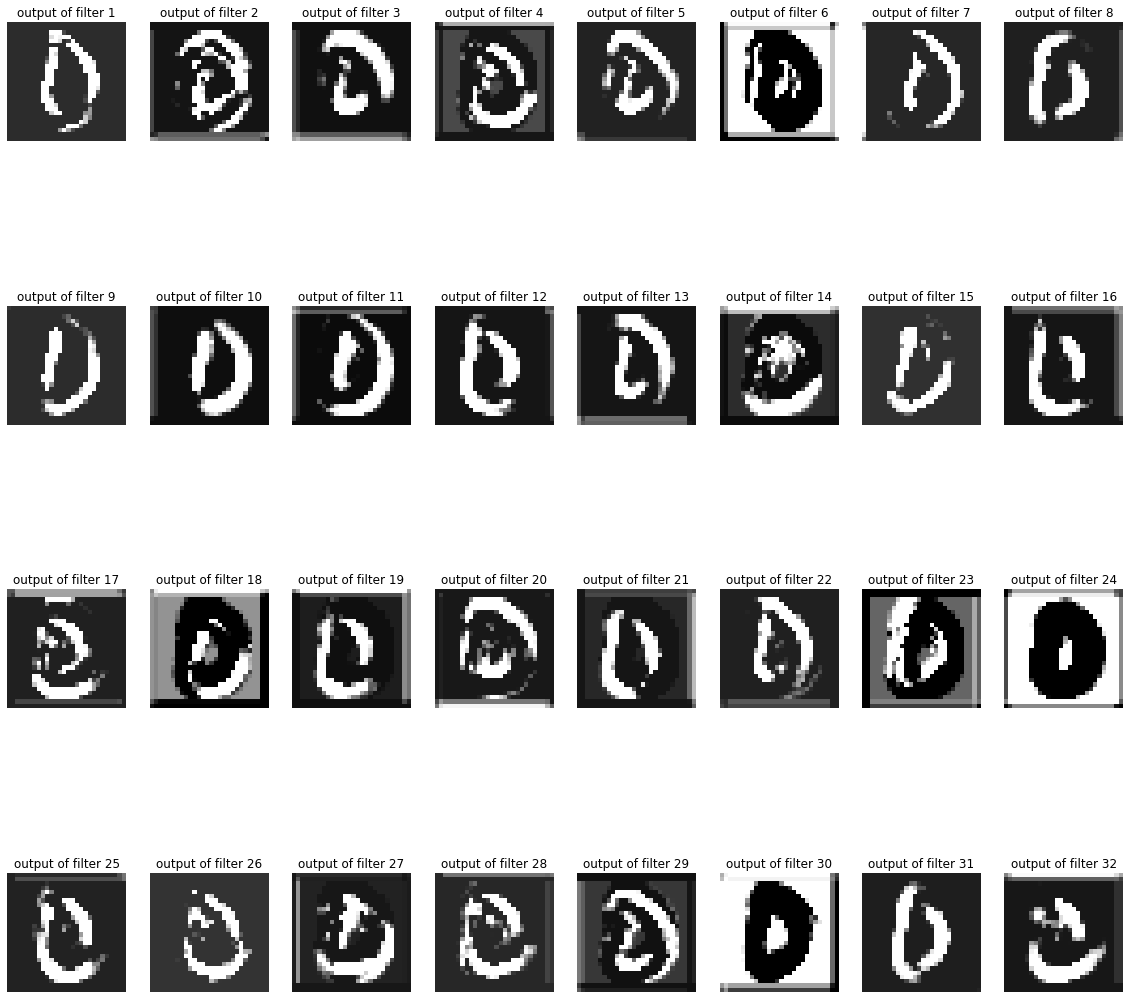

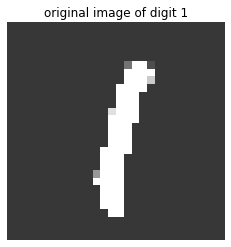

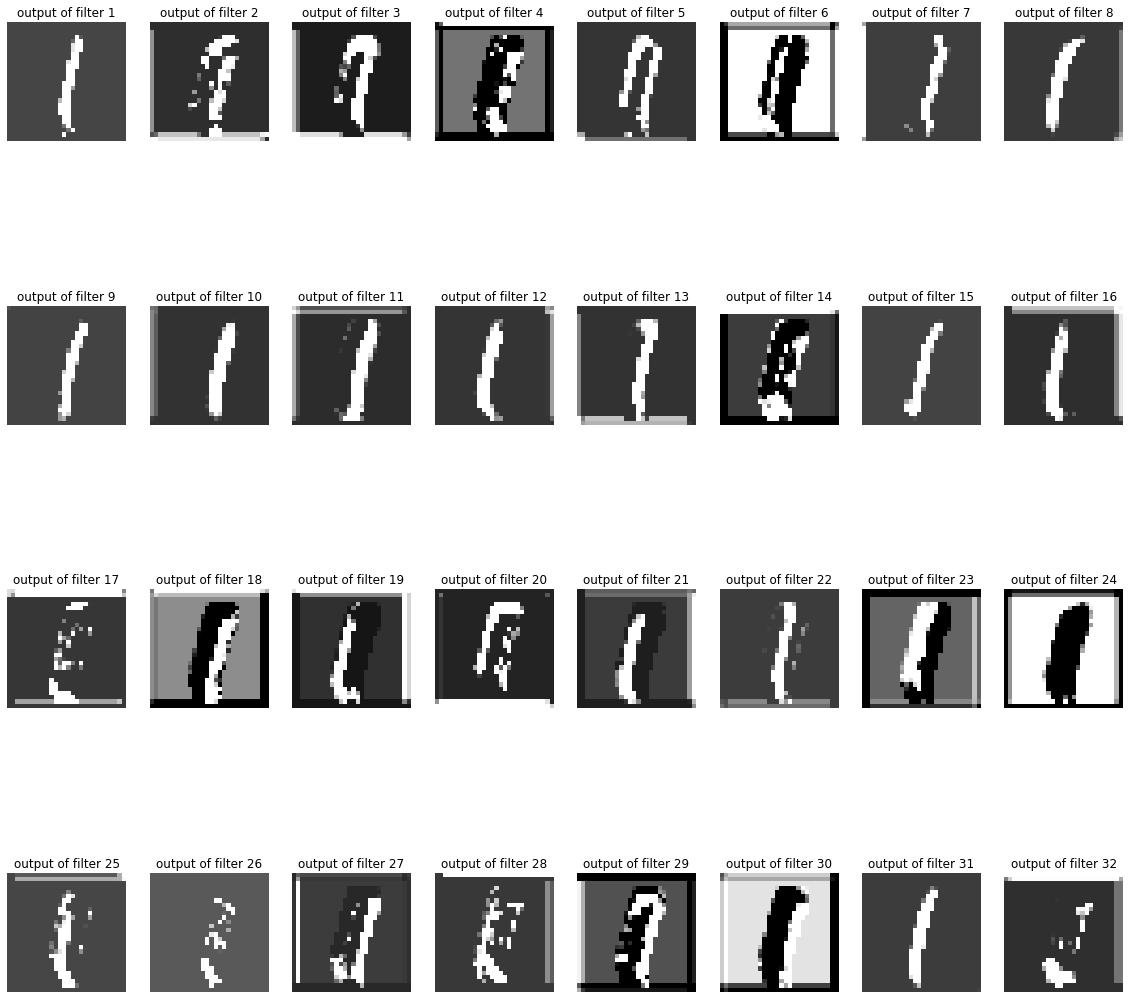

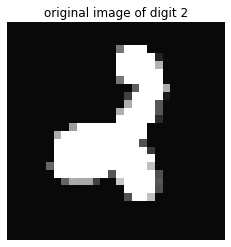

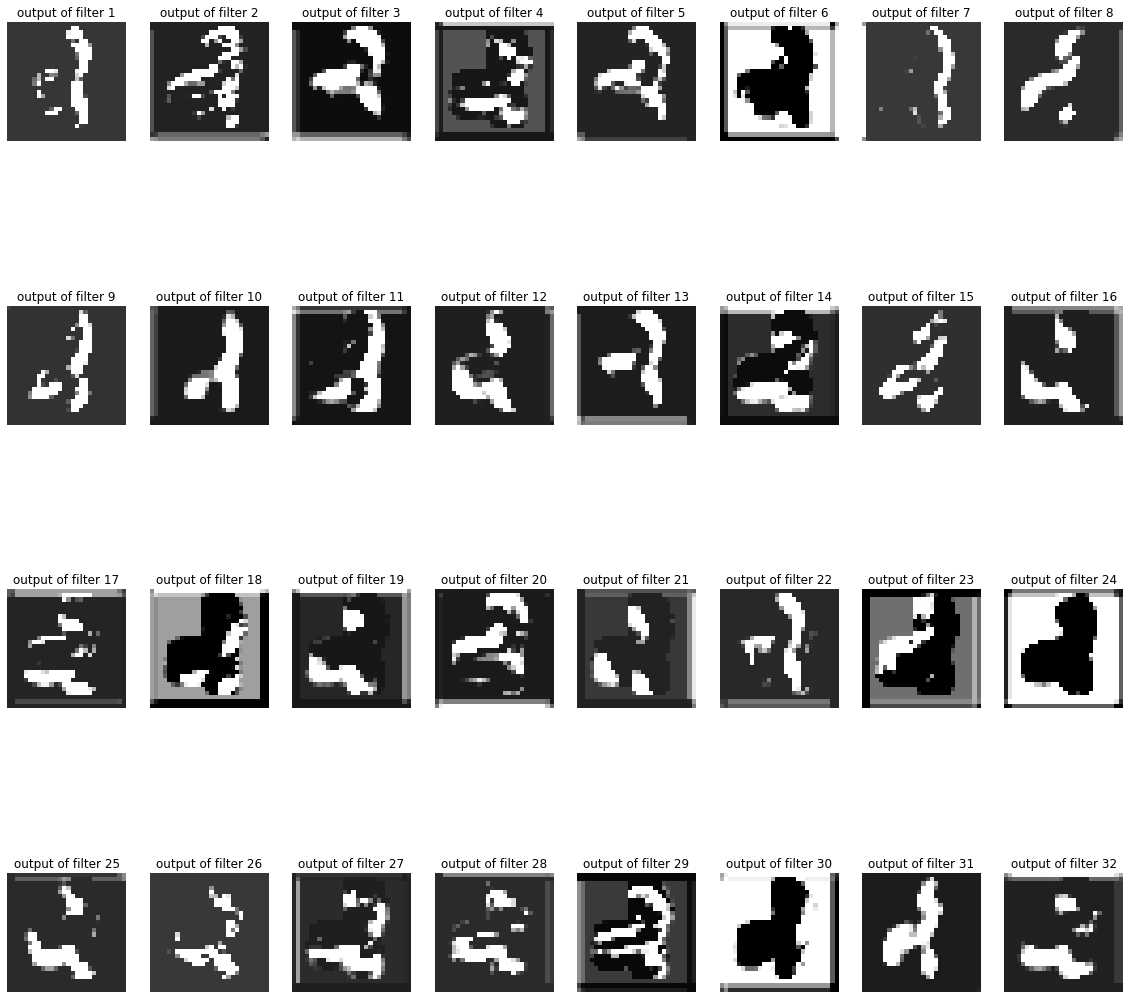

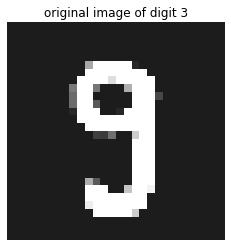

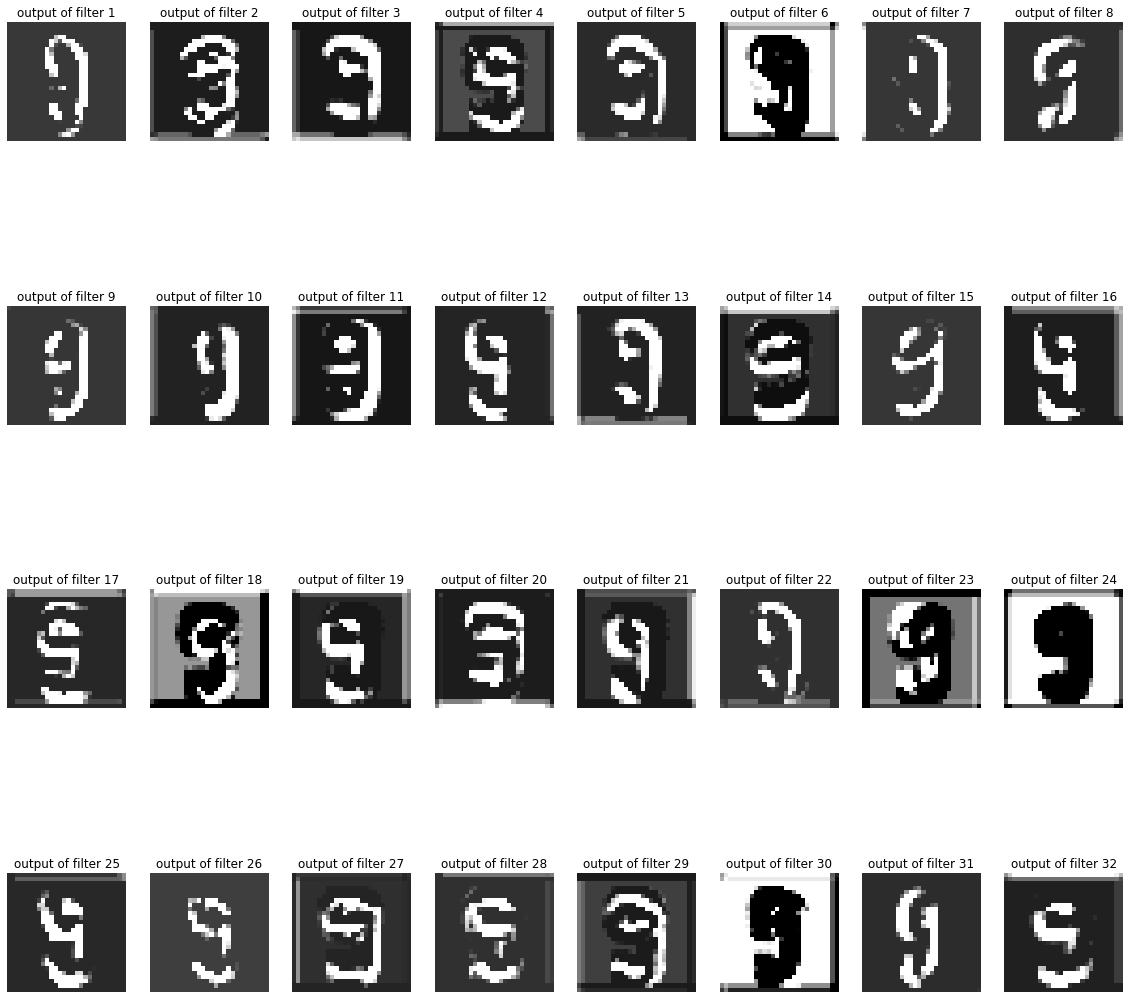

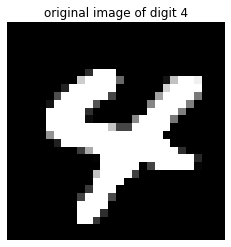

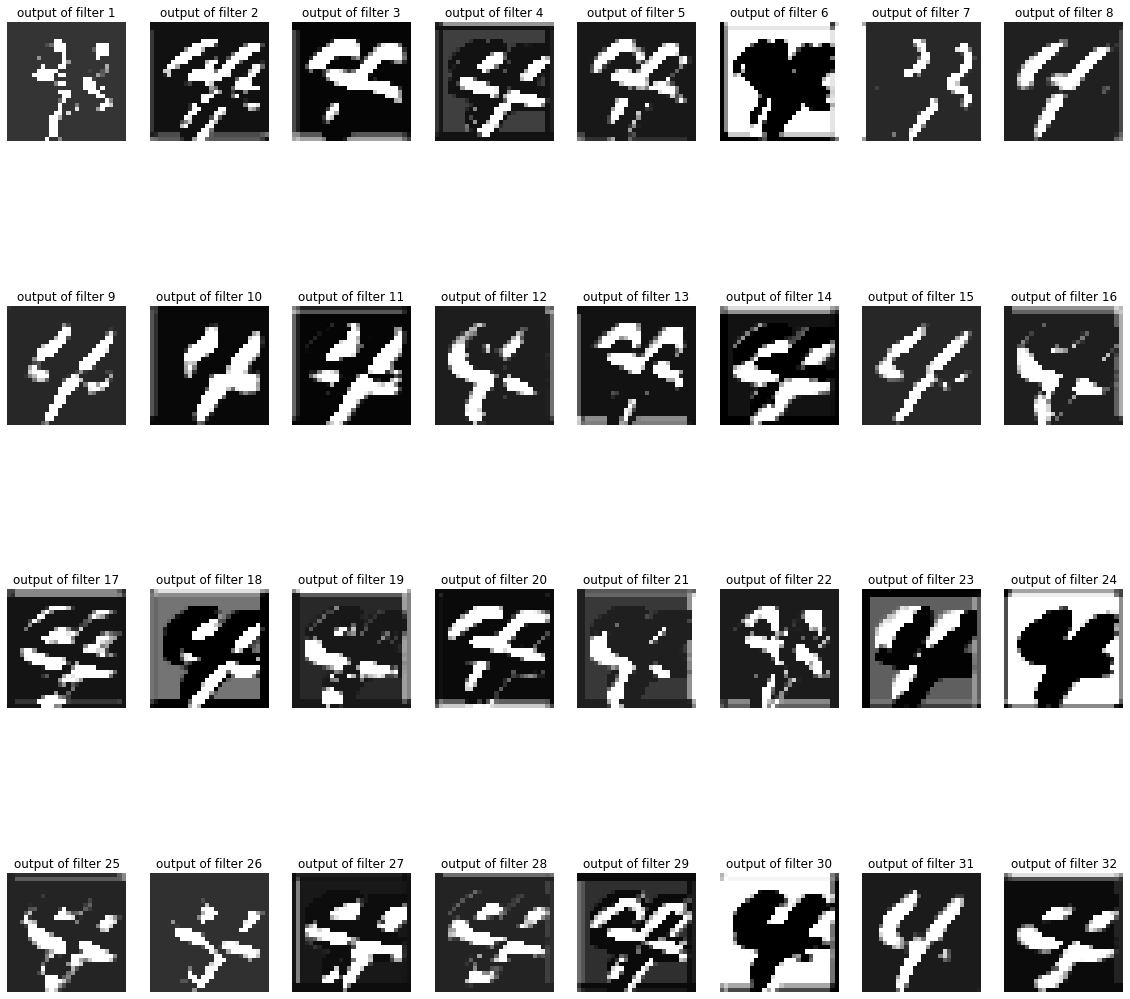

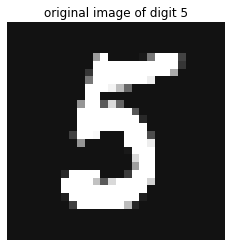

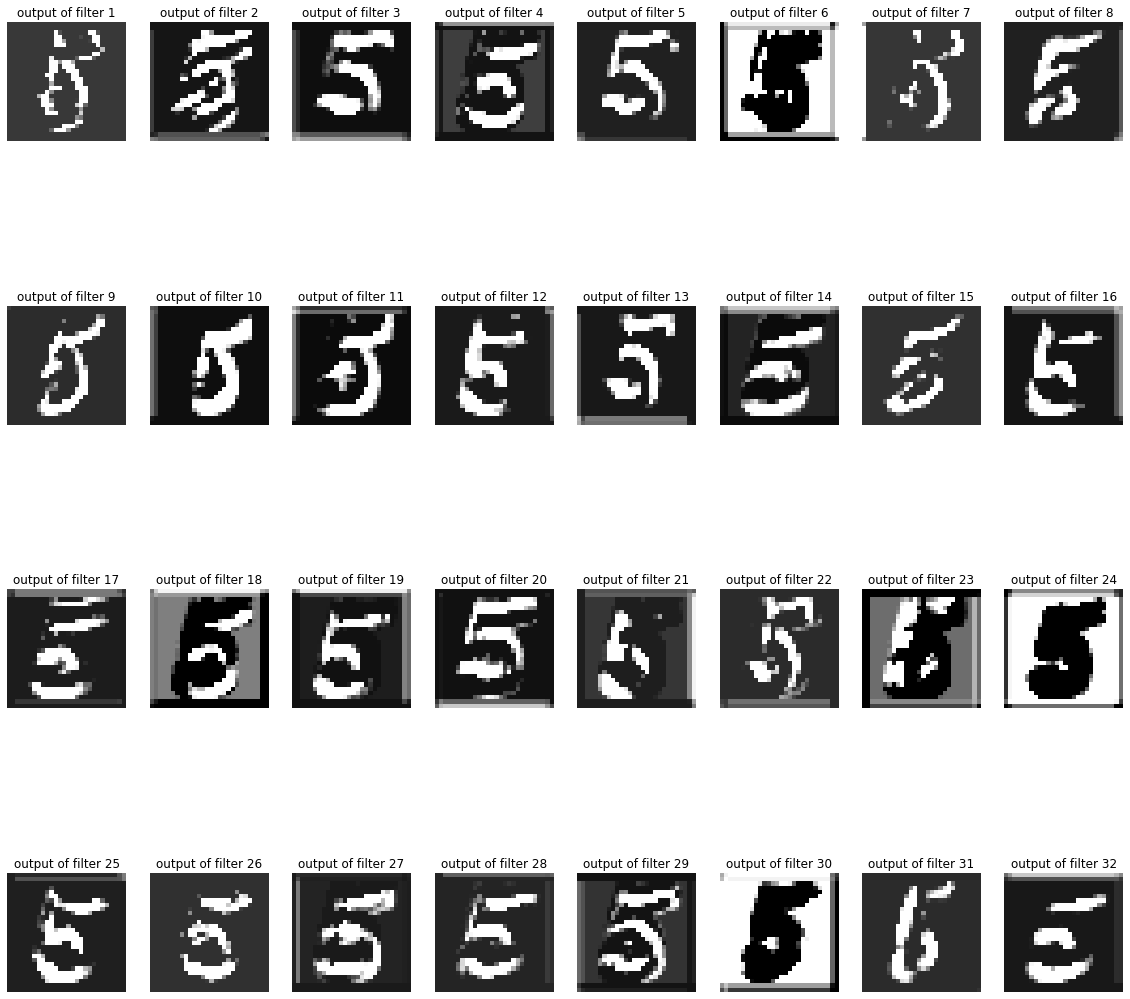

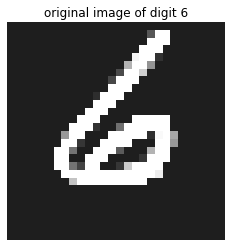

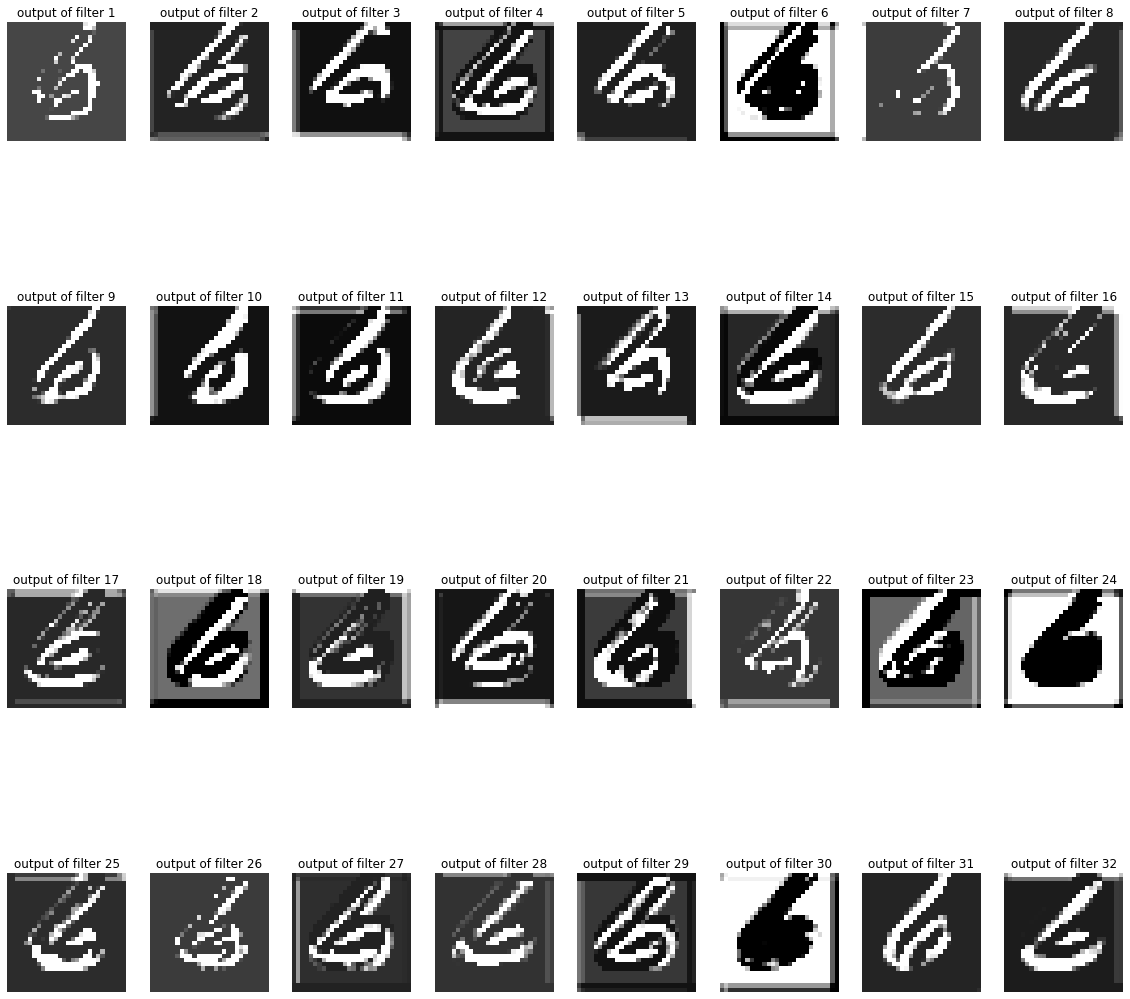

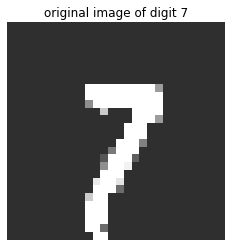

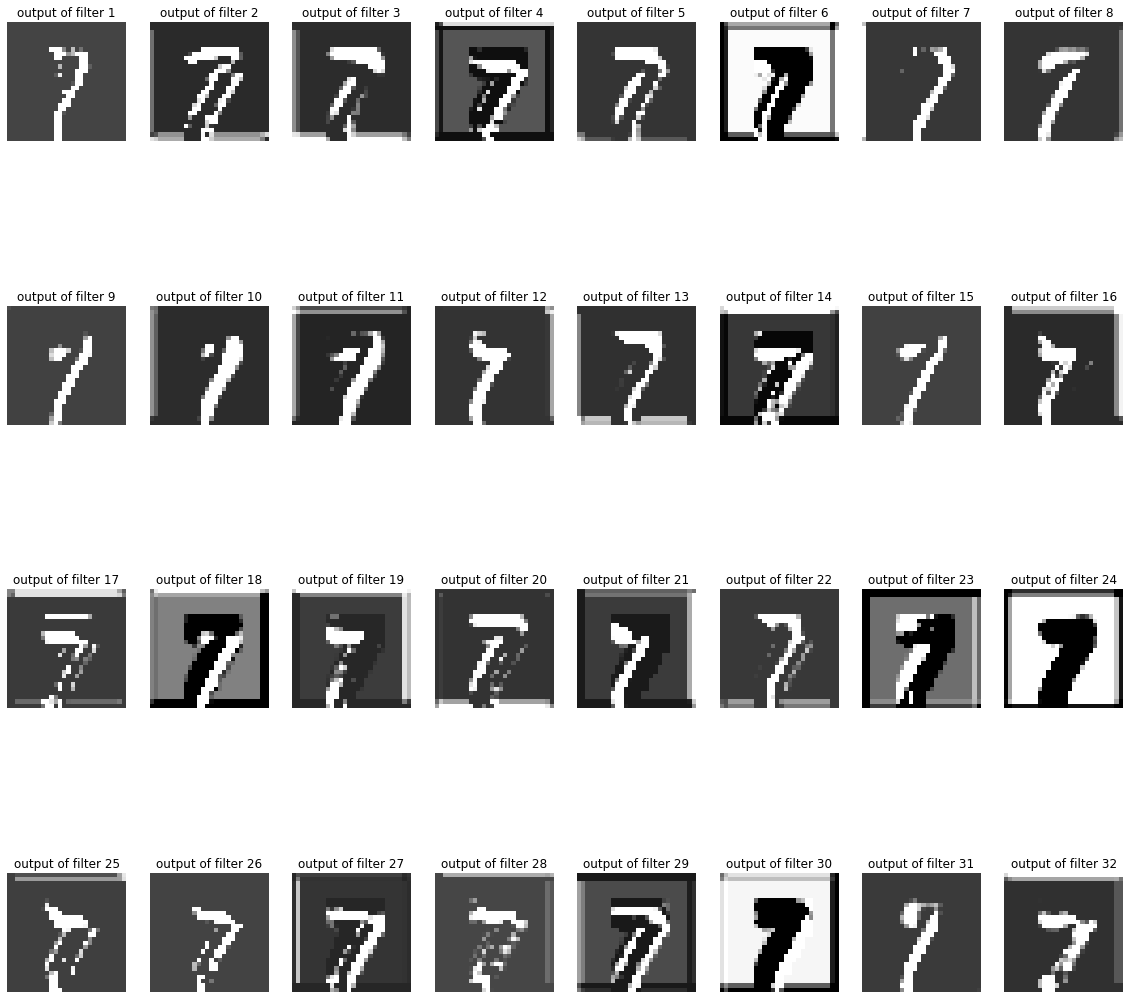

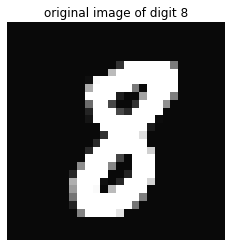

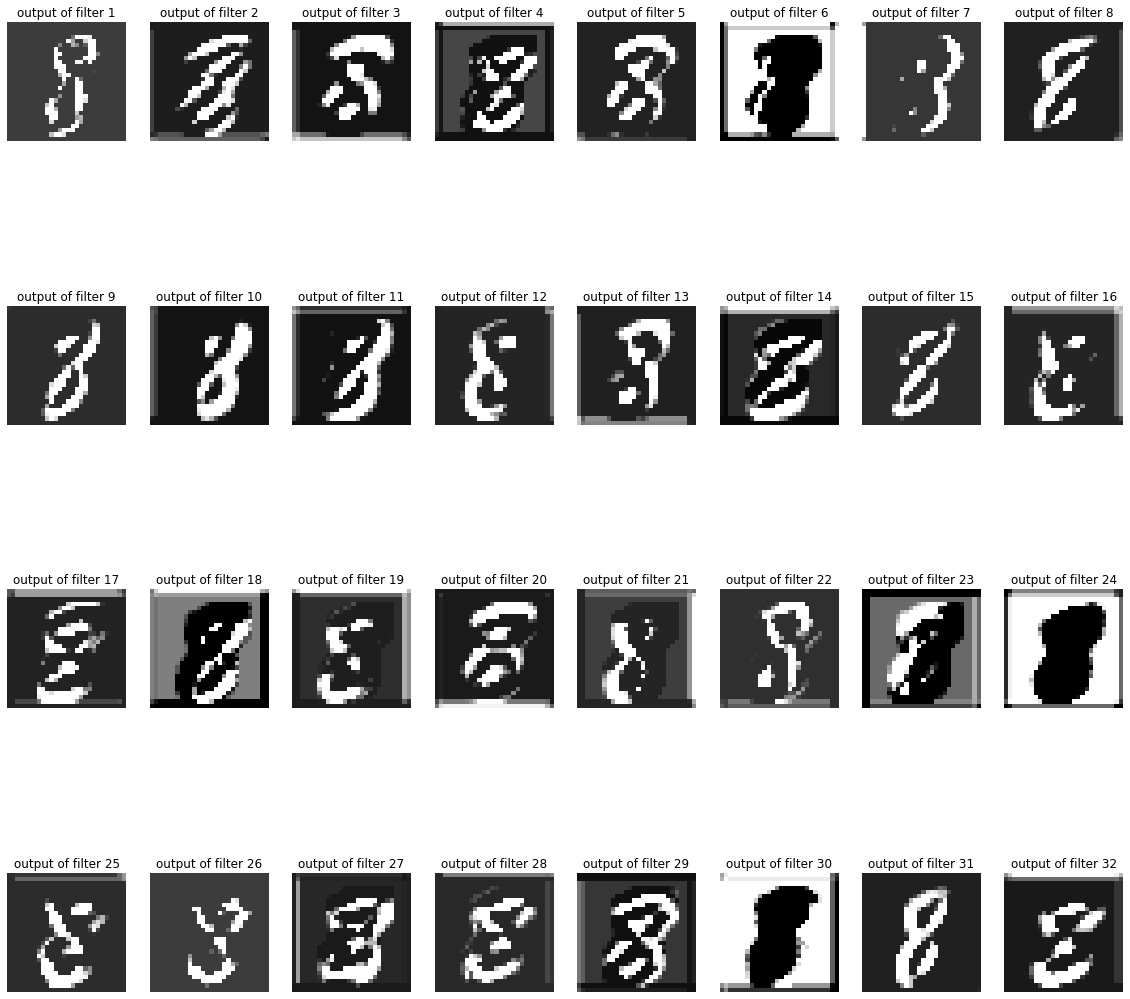

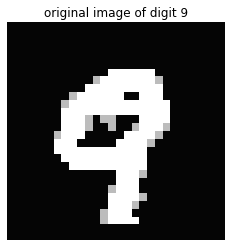

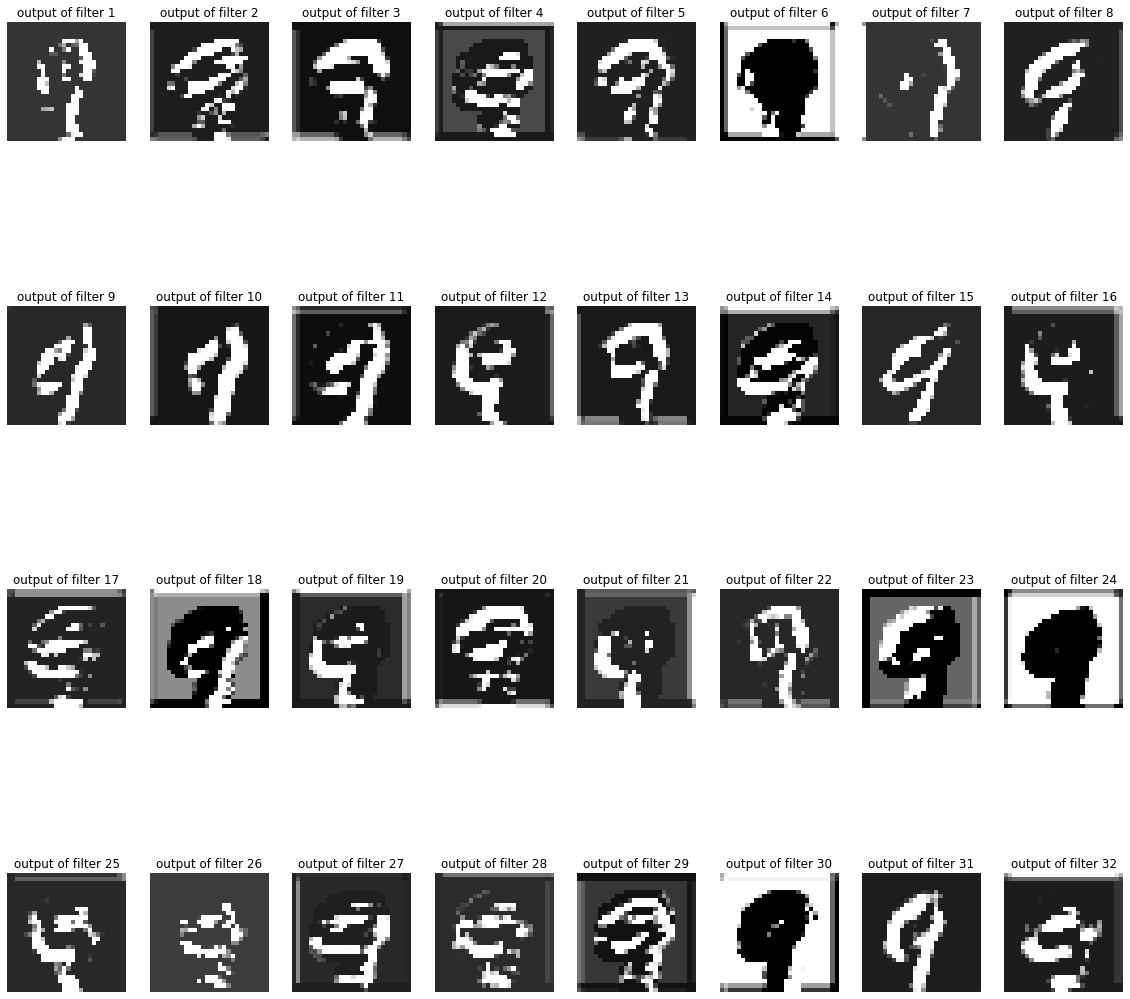

In [20]:

# picking one sample from each label for visualizing purposes
sample_digits = dict()
for data in train_loader:
    for i in range(data[1].shape[0]):
        if data[1][i].item() not in sample_digits.keys():
            sample_digits[data[1][i].item()] = data[0][i]
    if len(sample_digits.keys()) == 10:
        break

for digit in range(10):
    # plot original image
    plt.figure()
    data = sample_digits[digit]
    npimg = data[0].numpy()
    npimg = normalize_image(npimg)
    plt.imshow(npimg, cmap="gray", vmin=0, vmax=1)
    plt.title("original image of digit %d"%digit)
    plt.axis("off")
    plt.figure(figsize=(20, 20))
    
    with torch.no_grad():
        data = data.unsqueeze(0).to(device)
        # ACT22
        # data has shape (1,1,28,28)
        # pass the data to only layer conv1 and apply RELU activation (do not apply maxpooling)
        # the output should be tensor of size (1,32,28,28)

        activation = {}
        def get_activation(name):
            def hook(model, input, output):
                activation[name] = output.detach()
            return hook

        layer_name = 'conv_1'
        net.conv1.register_forward_hook(get_activation(layer_name))
        output = net(data)
        output = F.relu(activation[layer_name])
        act = output.squeeze()
        
        # plot image feature maps
        data_numpy = act.detach().cpu().numpy()
        for i in range(32):
            plt.subplot(4, 8, i + 1)
            npimg = data_numpy[i]
            npimg=normalize_image(npimg)
            plt.imshow(npimg, cmap="gray", vmin=0, vmax=1)
            plt.title("output of filter " + str(i + 1))
            plt.axis("off")
        plt.show()
        
        # Tests
        assert(data.size()==(1, 1, 28, 28))
        assert(output.size()==(1, 32, 28, 28))